In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns

np.random.seed(42)
# plt.rcParams['figure.facecolor'] = 'white'

# Modelo de posicionamiento: P-medianas Tipo Demanda
En este notebook, usando los datos obtenidos y creados anteriormente, pondremos a prueba diferentes maneras de enfrentarnos al problema planteado, este consiste en una variacion de las P-Medianas, donde debemos ajustar la posicion de nuevos centros de salud minimizando la distancia ponderada por la demanda de cada manzana considerando 3 tipos de centros de salud, cada uno con una demanda especifica para cada grupo de edad.

In [86]:
# Cargamos los datos
# Poblacion contiene la ubicacion en el plano y el numero de personas por grupo de edad
poblacion = pd.read_csv('input_modelo_poblacion.csv')
# Salud contiene la ubicacion y el tipo de centro de salud instalado, ademas de las nuevas opciones 
salud = pd.read_csv('input_modelo_salud.csv')
# Este contiene el factor aplicado a la distancia para cada centro de salud y edad
factores = pd.read_csv('input_modelo_factores.csv')

In [87]:
salud

,Tipo,x,y
0,Hospital,-31.062672,-18.878255
1,Rutinario,-74.315933,-52.485582
2,Rutinario,-29.300285,25.872194
3,Rutinario,18.744170,-2.489830
4,Rutinario,-0.416822,47.727023
5,Rutinario,-28.162589,-19.399550
6,Rutinario,1.330421,-15.097970
7,Rutinario,54.802121,-23.539348
8,Rutinario,-31.412878,-35.171409
9,Rutinario,-26.439955,-49.382980


In [4]:
# Provisionalmente usaremos los nuevos centros como posiciones aleatorias de la poblacion
salud = pd.concat([salud, poblacion.iloc[np.random.randint(0, len(poblacion),20)][['x','y']]]).reset_index(drop=True)
salud.loc[salud.Tipo.isna(),'Tipo'] = 'Por Definir'

In [5]:
# Calculamos la demanda ponderada por cuada hacia cada centro de salud
edades = poblacion[['Edad<5', 'Edad5-14', 'Edad15-64', 'Edad>64']].to_numpy()
fac = factores[['Edad<5', 'Edad5-14', 'Edad15-64', 'Edad>64']].to_numpy()
demanda = edades.dot(fac.T)
demanda = np.hstack([(np.zeros((len(edades),1))+np.inf),demanda])
print(demanda.shape)

(3738, 4)


In [6]:
# Calculamos la distancia entre las manzanas y los centros de salud
pos_manzanas = poblacion[['x','y']].to_numpy()
pos_salud = salud[['x','y']].to_numpy()
distancias = np.linalg.norm(pos_manzanas[:, None, :] - pos_salud[None, :, :], axis = -1, ord = np.inf)
distancias.shape

(3738, 41)

In [7]:
# Funcion que define a que centro de salud se asigna cada manzana
# Este toma la distancia minima ponderada a cada centro
# Variar esta funcion puede hacer que el problema sea capacitado o no
def asignation(supplys_types, distances, ages_demand):
    asig = np.zeros(distances.shape[0], dtype=int)
    sol_cost = 0
    for i in range(distances.shape[0]):
        weighted_dists = distances[i]*np.array([ages_demand[i,j] for j in supplys_types])
        pos = np.nanargmin(weighted_dists)
        asig[i] = pos
        sol_cost += weighted_dists[pos]
    return asig, sol_cost


def score(new_types, fixed_types, distances, ages_demand):
    supplys_types = np.hstack((fixed_types,new_types))
    asig, sol_cost = asignation(supplys_types, distances, ages_demand)
    return sol_cost, asig

In [8]:
presupuesto_inicial = 250
#        N,  H,  R,  U
costo = [0, 100, 25, 40]

In [9]:
dic = {'Por Definir':0, 'Hospital':1, 'Rutinario':2,'Urgencias':3}
centros_fijos = [dic[tipo] for tipo in salud[salud.Tipo != 'Por Definir'].Tipo]
centros_nuevos = [dic[tipo] for tipo in salud[salud.Tipo == 'Por Definir'].Tipo]
sol_base, asig = score(centros_nuevos, centros_fijos, distancias, demanda)

## Algoritmo Greedy

In [23]:
presupuesto = presupuesto_inicial
mejor_solucion = centros_nuevos
mejor_score = sol_base
while presupuesto > np.min(costo):
    centros_nuevos = mejor_solucion.copy()
    mejor_mejora = 0
    mejor_centro = [0,0]
    for j in range(len(centros_nuevos)):
        if centros_nuevos[j] > 0:
            continue
        for k in range(1,4):
            centros_nuevos[j] = k
            nuevo_score, asig = score(centros_nuevos, centros_fijos, distancias, demanda)
            mejora = (mejor_score-nuevo_score)*costo[k]/presupuesto_inicial
            if mejora > mejor_mejora and np.sum([costo[i] for i in centros_nuevos])<presupuesto_inicial:
                mejor_mejora = mejora
                mejor_centro = [j,k]
                mejor_score = nuevo_score
        centros_nuevos[j] = 0
    print(mejor_mejora, mejor_centro)
    mejor_solucion[mejor_centro[0]] = mejor_centro[1]
    presupuesto-= costo[mejor_centro[1]]
    print(presupuesto)
print(score(mejor_solucion, centros_fijos, distancias, demanda))

/tmp/ipykernel_10327/2207914518.py:8: RuntimeWarning: invalid value encountered in multiply
  weighted_dists = distances[i]*np.array([ages_demand[i,j] for j in supplys_types])


32037.04697374042 [7, 1]
100
726.9282003266329 [13, 3]
60
545.2658423089713 [0, 3]
20
0 [0, 0]
20
224.61327666268917 [9, 3]
-20
(250471.5390652176, array([0, 0, 0, ..., 0, 0, 0]))


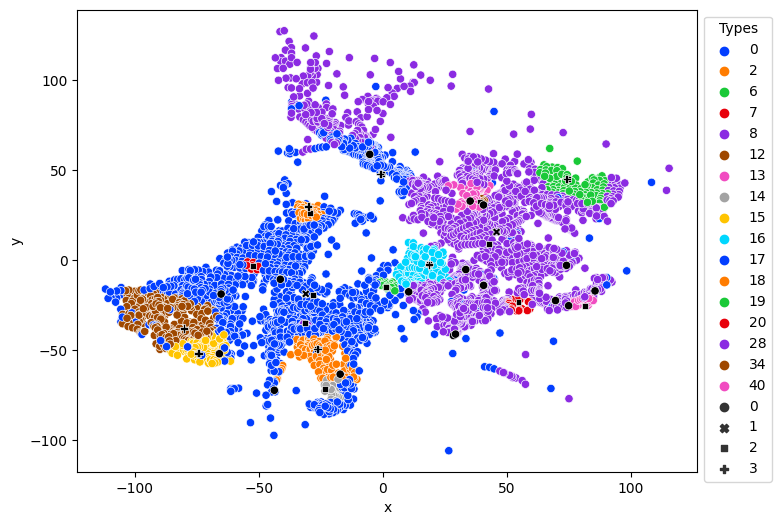

In [29]:
def asignation_plot(asig, demand_pos, supply_pos, supplys_types):
    supply = pd.DataFrame(supply_pos, columns=['x','y'])
    supply['Types'] = supplys_types
    demand = pd.DataFrame(demand_pos, columns=['x','y'])
    demand['Asignation'] = asig
    plt.figure(figsize = (8,6))
    ax = sns.scatterplot(data=demand, x = 'x', y = 'y', hue = 'Asignation', palette = 'bright')
    sns.scatterplot(ax = ax, data=supply, x = 'x', y = 'y', style = 'Types', color = 'k')
    # sns.scatterplot(ax = ax, data=supply_pos)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.plot()
asignation_plot(asig, pos_manzanas, pos_salud, np.hstack((centros_fijos,mejor_solucion)))

In [57]:
arr = np.array(centros_fijos)
fijos = np.zeros((arr.size, arr.max()+1), dtype=int)
fijos[np.arange(arr.size),arr] = 1

[[0 1 0 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 1 0]]


In [85]:
import pulp

I = range(len(distancias)) # Número de manzanas 
J = range(len(salud))  # Número de posibles ubicaciones para centros de salud 
K = range(4)   # Tipos de centros de salud (0, 1, 2, 3) 
F = fijos

# Matriz de demanda 
Demand = {(i, k): demanda[i,k] for i in I for k in K}  

# Costos de instalación actualizados
Costos_instalacion = [0, 100, 25, 40]
C = {(j, k): Costos_instalacion[k] for j in J for k in K}

# Presupuesto máximo para instalaciones
Presupuesto_maximo = 200

# Crear el problema de optimización (ajustado)
prob = pulp.LpProblem("Health_Center_Location_Adjusted", pulp.LpMinimize)

# Variables de decisión (redefinidas para incluir la nueva configuración)
x = pulp.LpVariable.dicts("x", [(i, j, k) for i in I for j in J for k in K], 
                          cat=pulp.LpBinary)
y = pulp.LpVariable.dicts("y", [(j, k) for j in J for k in K], 
                          cat=pulp.LpBinary)

# Función objetivo (ajustada para reflejar solo la distancia ponderada por la demanda)
prob += pulp.lpSum([distancias[i, j] * Demand[i, k] * x[i, j, k] for i in I for j in J for k in K])

# Restricciones
# 1. Cada persona es asignada a exactamente un centro de salud
for i in I:
    prob += pulp.lpSum([x[i, j, k] for j in J for k in K]) == 1

# 2. Solo se puede asignar una persona a un centro de salud si este ha sido instalado
for i in I:
    for j in J:
        for k in K:
            prob += x[i, j, k] <= y[j, k]

# Los centros fijos tiene su tipo previamente definido
for j in J[:len(F)]:
    for k in K:
        prob += y[j,k] == F[j,k]

# Los centros pueden ser de un solo tipo
for j in J:
    prob += pulp.lpSum([y[j,k] for k in K]) <= 1

# 3. Restricción de presupuesto para instalaciones
prob += pulp.lpSum([C[j, k] * y[j, k] for j in J[len(F):] for k in K]) <= Presupuesto_maximo

# Resolver el problema
prob.solve()

# Imprimir el resultado
for i in range(len(salud)):
    text = str(i)+ ' '
    for j in range(4):
        text+= str(y[i,j].varValue)+ ' '
    print(text)

# Verificar el estado de la solución
print("Status:", pulp.LpStatus[prob.status])

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/gmezap/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/a1df3bd1377c490ab971cd6c6bfda0fd-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/a1df3bd1377c490ab971cd6c6bfda0fd-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 616901 COLUMNS
At line 4281136 RHS
At line 4898033 BOUNDS
At line 5511230 ENDATA
Problem MODEL has 616896 rows, 613196 columns and 1839404 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 226361 - 28.51 seconds
Cgl0002I 63 variables fixed
Cgl0004I processed model has 302799 rows, 302858 columns (302858 integer (302858 of which binary)) and 900998 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 226361
Cbc0038I Before mini branch and bound, 302740 integers at bound fixed and 118 continuou